# Zwift Cycling Performance Analysis

This notebook analyzes cycling performance data from a Zwift GPX file, focusing on power metrics and other performance indicators. We'll extract, process, and visualize the data to gain insights into the cycling session.

## Import Required Libraries

First, we'll import the necessary libraries for working with GPX data, data manipulation, and visualization.

In [2]:
# Install required packages
%pip install gpxpy

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpxpy
from datetime import datetime
import os

# Set plot style
plt.style.use('ggplot')
sns.set_context("notebook", font_scale=1.2)

# Display plots inline
%matplotlib inline

## Load and Parse GPX Data

Next, we'll load the GPX file that contains our Zwift cycling data and parse it to extract the relevant information.

In [4]:
# Define the path to the GPX file
gpx_file_path = 'data/zwift-data.gpx'  # Path relative to the notebook location

# Check if the file exists
if os.path.isfile(gpx_file_path):
    print(f"GPX file found: {gpx_file_path}")
else:
    # Try absolute path since we know the project structure
    gpx_file_path = 'c:/Users/milively/Documents/_dev_work/playground-0/zwift-data.gpx'
    if os.path.isfile(gpx_file_path):
        print(f"GPX file found at absolute path: {gpx_file_path}")
    else:
        print(f"GPX file not found. Please check the file path.")

# Display the first few lines of the GPX file to understand its structure
try:
    with open(gpx_file_path, 'r') as gpx_file:
        lines = gpx_file.readlines()[:20]  # First 20 lines
        print("\nFirst few lines of the GPX file:")
        print(''.join(lines))
except Exception as e:
    print(f"Error reading file: {e}")

GPX file found: data/zwift-data.gpx

First few lines of the GPX file:
<?xml version="1.0" encoding="UTF-8"?>
<gpx xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.topografix.com/GPX/1/1 http://www.topografix.com/GPX/1/1/gpx.xsd http://www.garmin.com/xmlschemas/GpxExtensions/v3 http://www.garmin.com/xmlschemas/GpxExtensionsv3.xsd http://www.garmin.com/xmlschemas/TrackPointExtension/v1 http://www.garmin.com/xmlschemas/TrackPointExtensionv1.xsd" creator="StravaGPX" version="1.1" xmlns="http://www.topografix.com/GPX/1/1" xmlns:gpxtpx="http://www.garmin.com/xmlschemas/TrackPointExtension/v1" xmlns:gpxx="http://www.garmin.com/xmlschemas/GpxExtensions/v3">
 <metadata>
  <time>2025-04-30T04:11:56Z</time>
 </metadata>
 <trk>
  <name>Zwift - 90min Riders Choice on Tempus Fugit in Watopia</name>
  <type>VirtualRide</type>
  <trkseg>
   <trkpt lat="-11.6361510" lon="166.9725130">
    <ele>13.0</ele>
    <time>2025-04-30T04:11:56Z</time>
    <extensions>
     <po

In [5]:
# Parse the GPX file using gpxpy
try:
    with open(gpx_file_path, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)

    print(f"GPX file parsed successfully!")
    print(f"Track name: {gpx.tracks[0].name if gpx.tracks else 'No track name found'}")
    print(f"Number of track segments: {len(gpx.tracks[0].segments) if gpx.tracks else 0}")
    print(f"Number of trackpoints: {len(gpx.tracks[0].segments[0].points) if gpx.tracks and gpx.tracks[0].segments else 0}")

    # Get the first point to check available data
    if gpx.tracks and gpx.tracks[0].segments and gpx.tracks[0].segments[0].points:
        first_point = gpx.tracks[0].segments[0].points[0]
        print(f"\nSample point data:")
        print(f"  Time: {first_point.time}")
        print(f"  Latitude: {first_point.latitude}")
        print(f"  Longitude: {first_point.longitude}")
        print(f"  Elevation: {first_point.elevation}")

        # Check for extensions (power, heart rate, cadence)
        if hasattr(first_point, 'extensions'):
            print(f"\nExtensions available: {first_point.extensions}")

            # Try to extract power data from the first point
            if first_point.extensions and 'power' in str(first_point.extensions):
                print("Power data is available!")
except Exception as e:
    print(f"Error parsing GPX file: {e}")

GPX file parsed successfully!
Track name: Zwift - 90min Riders Choice on Tempus Fugit in Watopia
Number of track segments: 1
Number of trackpoints: 4280

Sample point data:
  Time: 2025-04-30 04:11:56+00:00
  Latitude: -11.636151
  Longitude: 166.972513
  Elevation: 13.0

Extensions available: [<Element 'power' at 0x000001420C9E73D0>, <Element '{http://www.garmin.com/xmlschemas/TrackPointExtension/v1}TrackPointExtension' at 0x000001420C9E7470>]
Power data is available!


## Extract Cycling Performance Data

Now that we've confirmed the GPX file contains the necessary data, let's extract the power, heart rate, cadence, and other metrics into a structured DataFrame for analysis.

In [6]:
# Extract data from GPX file into a pandas DataFrame
def extract_data_from_gpx(gpx):
    data = []

    # Extract data from each track point
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                point_data = {
                    'timestamp': point.time,
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevation': point.elevation,
                    'power': None,
                    'heart_rate': None,
                    'cadence': None
                }

                # Extract extensions data (power, heart rate, cadence)
                if hasattr(point, 'extensions') and point.extensions:
                    # Convert extensions to string for easier parsing
                    ext_str = str(point.extensions)

                    # Extract power (direct extension)
                    if 'power' in ext_str:
                        # Find power tag in extensions
                        for ext in point.extensions:
                            if ext.tag == 'power':
                                try:
                                    point_data['power'] = int(ext.text)
                                except (ValueError, TypeError):
                                    pass

                    # Extract heart rate and cadence (in TrackPointExtension)
                    if 'TrackPointExtension' in ext_str:
                        for ext in point.extensions:
                            # Look for TrackPointExtension namespace
                            if 'TrackPointExtension' in ext.tag:
                                for child in ext:
                                    if 'hr' in child.tag:
                                        try:
                                            point_data['heart_rate'] = int(child.text)
                                        except (ValueError, TypeError):
                                            pass
                                    elif 'cad' in child.tag:
                                        try:
                                            point_data['cadence'] = int(child.text)
                                        except (ValueError, TypeError):
                                            pass

                data.append(point_data)

    # Create DataFrame
    df = pd.DataFrame(data)

    # Convert timestamp to datetime if it isn't already
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df['timestamp'] = pd.to_datetime(df['timestamp'])

    return df

# Extract data from the loaded GPX file
try:
    df_cycling = extract_data_from_gpx(gpx)

    # Display basic information about the DataFrame
    print(f"Data extracted successfully! DataFrame shape: {df_cycling.shape}")
    print("\nFirst 5 rows:")
    display(df_cycling.head())

    # Display summary statistics
    print("\nSummary statistics:")
    display(df_cycling.describe())

    # Check for missing values
    print("\nMissing values per column:")
    display(df_cycling.isna().sum())

except Exception as e:
    print(f"Error extracting data: {e}")


Data extracted successfully! DataFrame shape: (4280, 7)

First 5 rows:


,timestamp,latitude,longitude,elevation,power,heart_rate,cadence
0,2025-04-30 04:11:56+00:00,-11.636151,166.972513,13.0,106,129,14
1,2025-04-30 04:11:57+00:00,-11.636144,166.972513,13.0,119,128,22
2,2025-04-30 04:11:58+00:00,-11.636129,166.972512,13.0,121,126,31
3,2025-04-30 04:11:59+00:00,-11.636108,166.972513,13.0,136,125,3
4,2025-04-30 04:12:00+00:00,-11.636084,166.972514,13.0,169,124,41



Summary statistics:


,latitude,longitude,elevation,power,heart_rate,cadence
count,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000,4280.000000
mean,-11.648074,166.989989,13.675421,111.124533,180.910748,73.471729
std,0.007452,0.007734,0.936714,31.441138,10.194531,13.485025
min,-11.663629,166.972512,12.600000,0.000000,124.000000,0.000000
25%,-11.654366,166.984295,13.200000,103.000000,178.000000,75.000000
50%,-11.649164,166.990182,13.200000,112.000000,183.000000,76.000000
75%,-11.640932,166.996918,13.800000,124.000000,188.000000,77.000000
max,-11.634631,167.002794,17.600000,376.000000,197.000000,90.000000



Missing values per column:


timestamp     0
latitude      0
longitude     0
elevation     0
power         0
heart_rate    0
cadence       0
dtype: int64

## Power Data Analysis

Let's analyze the power data to understand your cycling performance. We'll calculate key metrics like average power, normalized power, and examine power distribution and zones.

In [8]:
# Calculate basic power metrics

# Duration of the activity in minutes
activity_duration_seconds = (df_cycling['timestamp'].max() - df_cycling['timestamp'].min()).total_seconds()
activity_duration_minutes = activity_duration_seconds / 60

# Basic power metrics
average_power = df_cycling['power'].mean()
max_power = df_cycling['power'].max()
median_power = df_cycling['power'].median()

# Power to weight ratio (assuming weight of 75kg - adjust as needed)
rider_weight_kg = 75  # Adjust this to your actual weight
power_to_weight = average_power / rider_weight_kg

# Print results
print(f"Activity Duration: {activity_duration_minutes:.1f} minutes")
print(f"\nPower Metrics:")
print(f"  Average Power: {average_power:.1f} watts")
print(f"  Maximum Power: {max_power} watts")
print(f"  Median Power: {median_power} watts")
print(f"  Power-to-Weight Ratio: {power_to_weight:.2f} watts/kg")

# Calculate power zones (based on FTP - assuming FTP is 95% of 20min max power, but you can adjust)
# For demonstration, let's estimate FTP as 95% of average power + 20% (just as an example)
# In practice, you would use your known FTP or calculate it properly
estimated_ftp = average_power * 1.15  # This is just a rough estimate for demonstration

print(f"\nEstimated FTP (for zone calculations): {estimated_ftp:.1f} watts")

# Define traditional power zones
power_zones = {
    'Zone 1 (Recovery)': (0, 0.55 * estimated_ftp),
    'Zone 2 (Endurance)': (0.55 * estimated_ftp, 0.75 * estimated_ftp),
    'Zone 3 (Tempo)': (0.75 * estimated_ftp, 0.90 * estimated_ftp),
    'Zone 4 (Threshold)': (0.90 * estimated_ftp, 1.05 * estimated_ftp),
    'Zone 5 (VO2 Max)': (1.05 * estimated_ftp, 1.20 * estimated_ftp),
    'Zone 6 (Anaerobic)': (1.20 * estimated_ftp, 1.50 * estimated_ftp),
    'Zone 7 (Neuromuscular)': (1.50 * estimated_ftp, float('inf'))
}

# Calculate time spent in each zone
time_in_zones = {}
for zone, (lower, upper) in power_zones.items():
    time_in_zone = len(df_cycling[(df_cycling['power'] >= lower) & (df_cycling['power'] < upper)])
    percentage = (time_in_zone / len(df_cycling)) * 100
    time_in_zones[zone] = {
        'seconds': time_in_zone,  # Each data point represents 1 second
        'minutes': time_in_zone / 60,
        'percentage': percentage
    }

# Display time in zones
print("\nTime in Power Zones:")
for zone, data in time_in_zones.items():
    print(f"  {zone}: {data['minutes']:.1f} minutes ({data['percentage']:.1f}%)")


Activity Duration: 74.6 minutes

Power Metrics:
  Average Power: 111.1 watts
  Maximum Power: 376 watts
  Median Power: 112.0 watts
  Power-to-Weight Ratio: 1.48 watts/kg

Estimated FTP (for zone calculations): 127.8 watts

Time in Power Zones:
  Zone 1 (Recovery): 3.8 minutes (5.3%)
  Zone 2 (Endurance): 5.7 minutes (7.9%)
  Zone 3 (Tempo): 31.5 minutes (44.1%)
  Zone 4 (Threshold): 21.6 minutes (30.2%)
  Zone 5 (VO2 Max): 5.7 minutes (8.0%)
  Zone 6 (Anaerobic): 2.6 minutes (3.7%)
  Zone 7 (Neuromuscular): 0.6 minutes (0.8%)


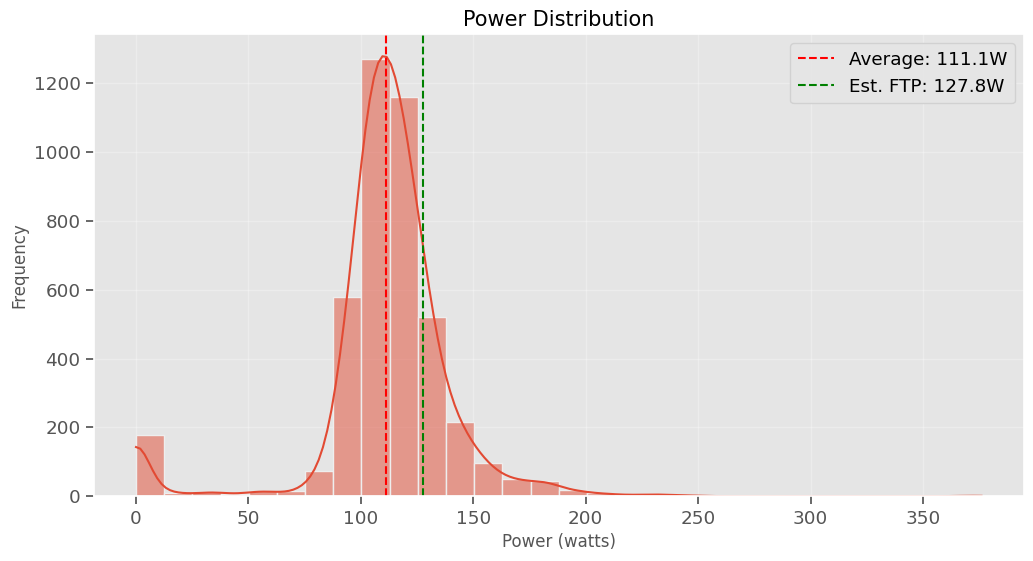

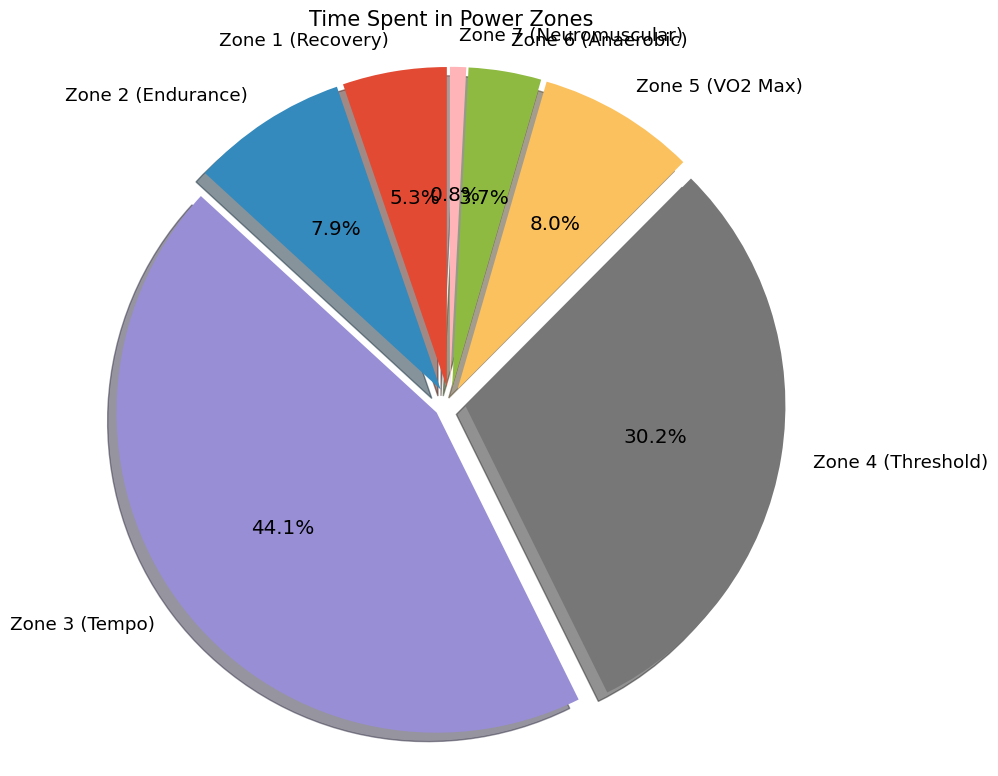

In [24]:
# Visualize power data distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_cycling['power'], bins=30, kde=True)
plt.title('Power Distribution', fontsize=15)
plt.xlabel('Power (watts)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(average_power, color='r', linestyle='--', label=f'Average: {average_power:.1f}W')
plt.axvline(estimated_ftp, color='g', linestyle='--', label=f'Est. FTP: {estimated_ftp:.1f}W')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Power zones distribution pie chart
zone_labels = list(time_in_zones.keys())
zone_percentages = [data['percentage'] for data in time_in_zones.values()]

plt.figure(figsize=(10, 8))
plt.pie(zone_percentages, labels=zone_labels, autopct='%1.1f%%', startangle=90,
        shadow=True, explode=[0.05]*len(zone_labels))
plt.title('Time Spent in Power Zones', fontsize=15)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()


## Power Analysis Over Time

Let's analyze how your power output changes over the duration of the ride. This will help identify any patterns, fatigue, or intervals during the session.

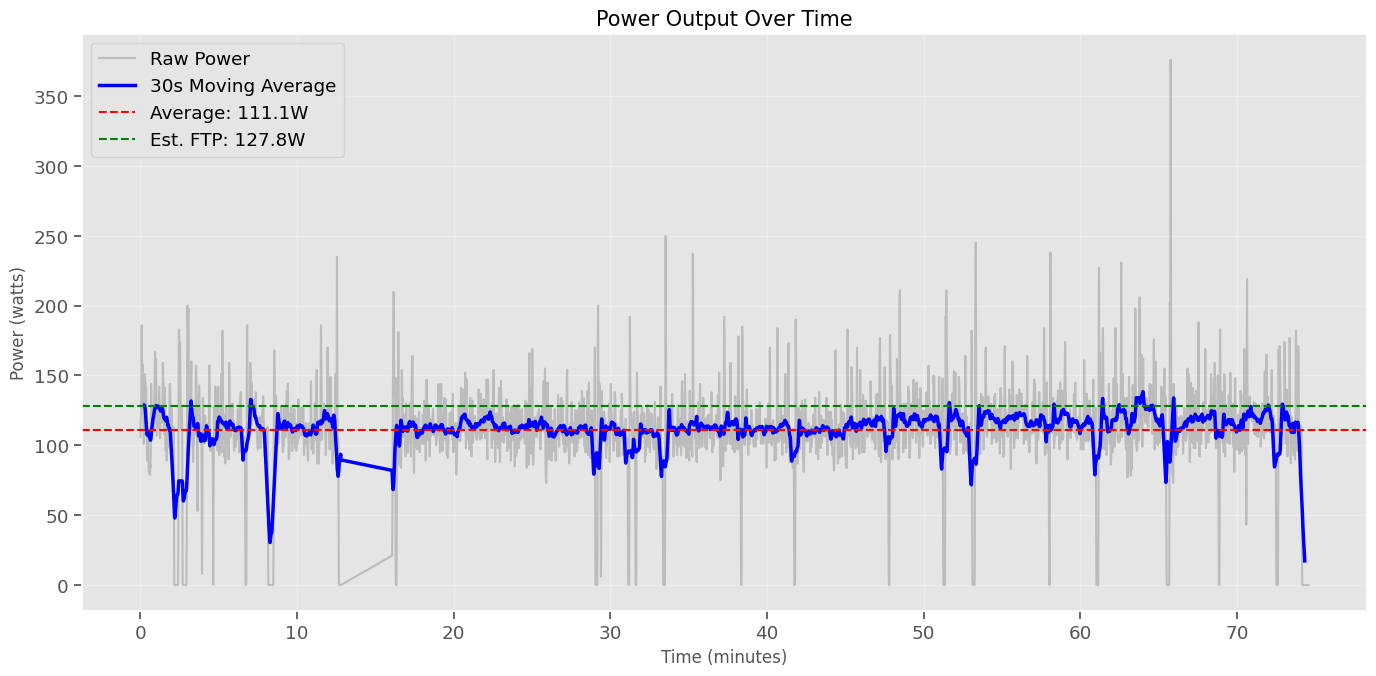

Best Average Powers:
  Best 5s power: 273.0 watts
  Best 20s power: 146.3 watts
  Best 1.0 minute power: 132.8 watts
  Best 5.0 minute power: 119.6 watts
  Best 20.0 minute power: 117.0 watts

FTP estimate (95% of 20min best): 111.2 watts


In [25]:
# Convert timestamp to minutes since start for easier plotting
start_time = df_cycling['timestamp'].min()
df_cycling['minutes'] = (df_cycling['timestamp'] - start_time).dt.total_seconds() / 60

# Create a power over time plot
plt.figure(figsize=(14, 7))

# Plot raw power data
plt.plot(df_cycling['minutes'], df_cycling['power'], alpha=0.4, color='gray', label='Raw Power')

# Create a smoothed power line (30-second moving average) to make the trend clearer
window_size = 30  # 30 seconds
df_cycling['power_smooth'] = df_cycling['power'].rolling(window=window_size, center=True).mean()
plt.plot(df_cycling['minutes'], df_cycling['power_smooth'], linewidth=2.5, color='blue', label=f'{window_size}s Moving Average')

# Add average power line
plt.axhline(average_power, color='r', linestyle='--', label=f'Average: {average_power:.1f}W')

# Add estimated FTP line
plt.axhline(estimated_ftp, color='g', linestyle='--', label=f'Est. FTP: {estimated_ftp:.1f}W')

# Formatting
plt.title('Power Output Over Time', fontsize=15)
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Power (watts)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Calculate 20-minute best power (commonly used for FTP estimation)
def rolling_average(data, window):
    return data.rolling(window=window).mean()

# Calculate various rolling averages
windows = [5, 20, 60, 300, 1200]  # 5s, 20s, 1min, 5min, 20min in seconds
best_powers = {}

for window in windows:
    window_name = f"{window}s"
    rolling_power = rolling_average(df_cycling['power'], window)
    best_power = rolling_power.max()
    best_powers[window_name] = best_power

# Display best powers
print("Best Average Powers:")
for window, power in best_powers.items():
    if int(window[:-1]) >= 60:
        minutes = int(window[:-1]) / 60
        print(f"  Best {minutes:.1f} minute power: {power:.1f} watts")
    else:
        print(f"  Best {window} power: {power:.1f} watts")

# Estimate FTP based on 95% of 20-minute best power
ftp_estimate = best_powers['1200s'] * 0.95
print(f"\nFTP estimate (95% of 20min best): {ftp_estimate:.1f} watts")


## Relationship Between Power, Heart Rate, and Cadence

Let's explore how your power output relates to heart rate and cadence. This can provide insights into efficiency and how your body responds to different intensity levels.

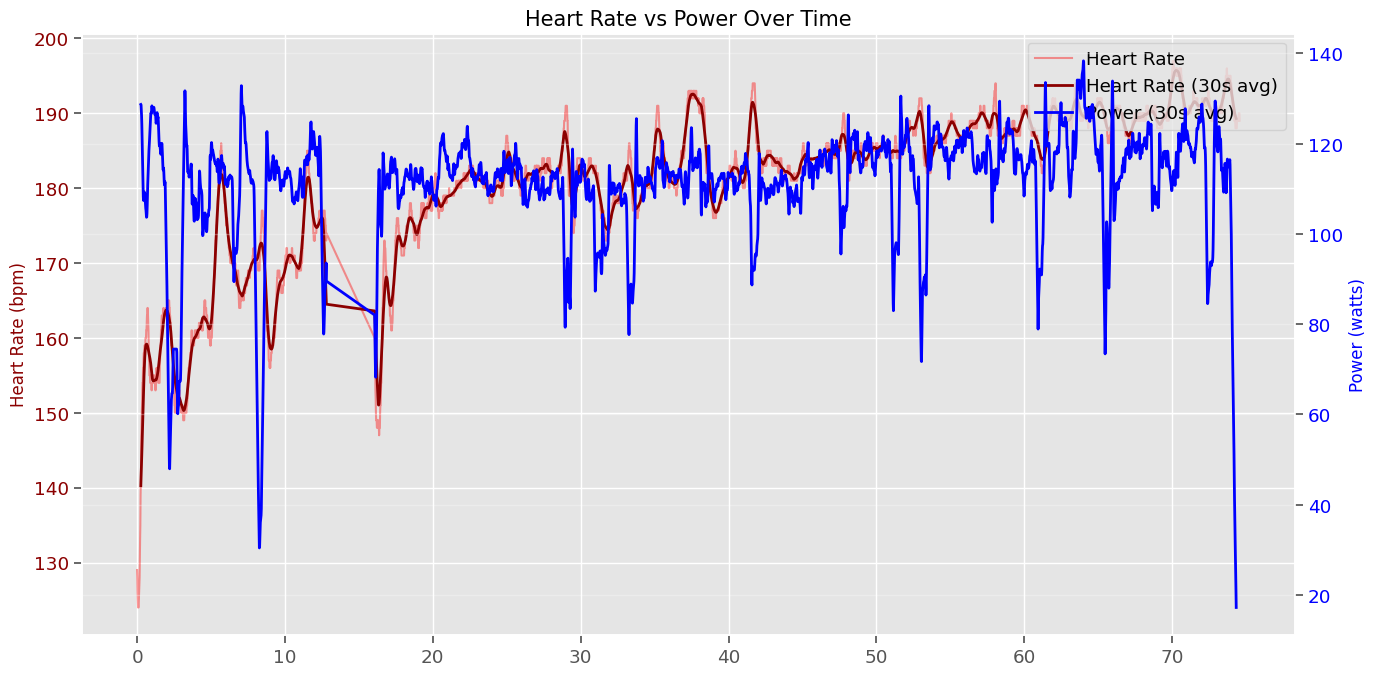

Heart Rate Statistics:
  Average Heart Rate: 180.9 bpm
  Maximum Heart Rate: 197.0 bpm

Average Heart Rate by Power Zone:
  Zone 1 (Recovery): 177.8 bpm
  Zone 2 (Endurance): 181.2 bpm
  Zone 3 (Tempo): 181.3 bpm
  Zone 4 (Threshold): 181.2 bpm
  Zone 5 (VO2 Max): 180.9 bpm
  Zone 6 (Anaerobic): 178.4 bpm
  Zone 7 (Neuromuscular): 181.4 bpm


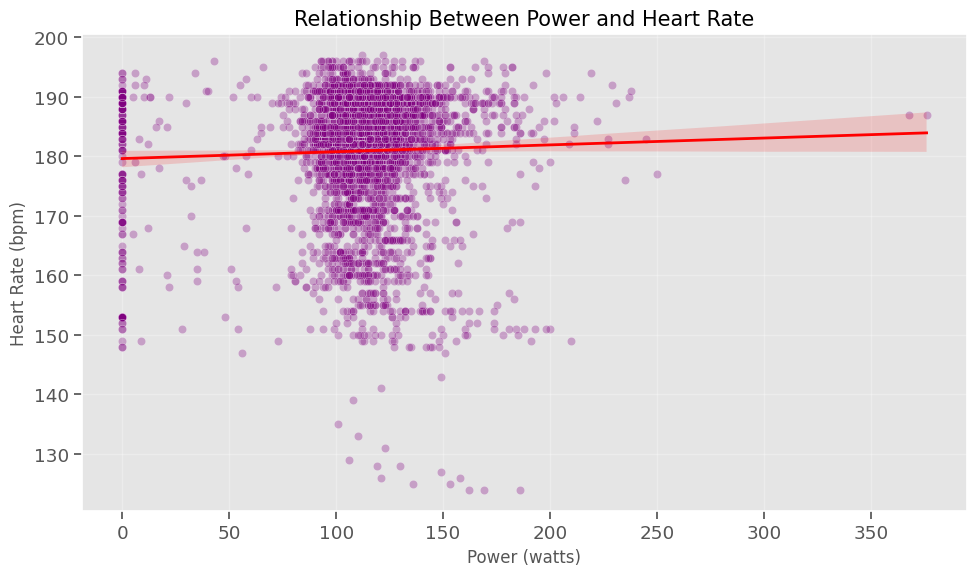

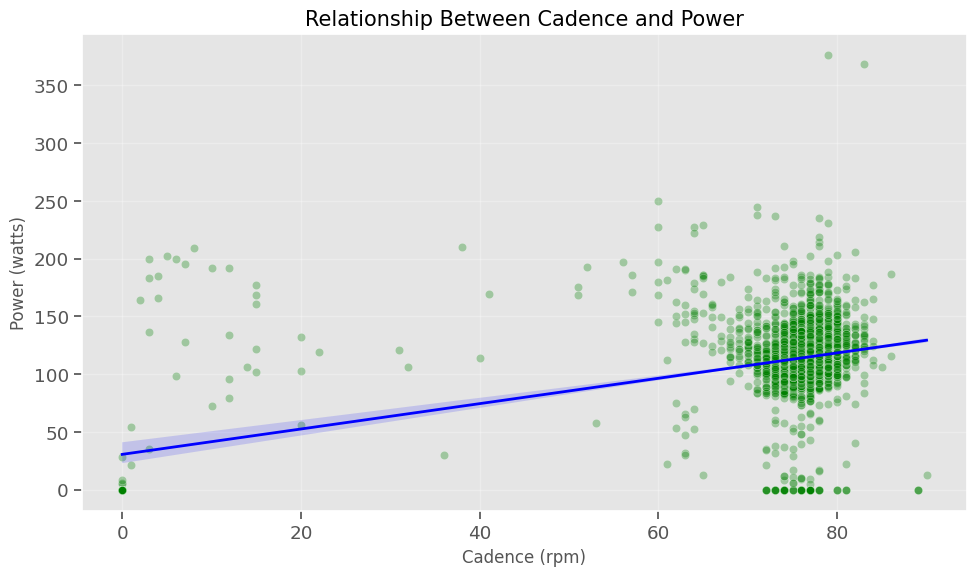

In [26]:
# Visualize heart rate over time with power overlay
plt.figure(figsize=(14, 7))

# Create two y axes
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot heart rate on primary axis
ax1.plot(df_cycling['minutes'], df_cycling['heart_rate'], color='red', alpha=0.4, label='Heart Rate')
ax1.plot(df_cycling['minutes'], df_cycling['heart_rate'].rolling(window=30, center=True).mean(),
         color='darkred', linewidth=2, label='Heart Rate (30s avg)')
ax1.set_ylabel('Heart Rate (bpm)', color='darkred', fontsize=12)
ax1.tick_params(axis='y', labelcolor='darkred')

# Plot power on secondary axis
ax2.plot(df_cycling['minutes'], df_cycling['power_smooth'], color='blue', linewidth=2, label='Power (30s avg)')
ax2.set_ylabel('Power (watts)', color='blue', fontsize=12)
ax2.tick_params(axis='y', labelcolor='blue')

# Add title and grid
plt.title('Heart Rate vs Power Over Time', fontsize=15)
plt.xlabel('Time (minutes)', fontsize=12)
plt.grid(True, alpha=0.3)

# Create combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

# Calculate and display heart rate and power statistics
avg_hr = df_cycling['heart_rate'].mean()
max_hr = df_cycling['heart_rate'].max()

print(f"Heart Rate Statistics:")
print(f"  Average Heart Rate: {avg_hr:.1f} bpm")
print(f"  Maximum Heart Rate: {max_hr:.1f} bpm")

# Calculate average heart rate for each power zone
print("\nAverage Heart Rate by Power Zone:")
for zone, (lower, upper) in power_zones.items():
    zone_data = df_cycling[(df_cycling['power'] >= lower) & (df_cycling['power'] < upper)]
    if not zone_data.empty:
        avg_zone_hr = zone_data['heart_rate'].mean()
        print(f"  {zone}: {avg_zone_hr:.1f} bpm")

# Scatter plot of power vs heart rate
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cycling, x='power', y='heart_rate', alpha=0.3, color='purple')

# Add a regression line
sns.regplot(data=df_cycling, x='power', y='heart_rate', scatter=False, color='red',
           line_kws={'linewidth': 2})

plt.title('Relationship Between Power and Heart Rate', fontsize=15)
plt.xlabel('Power (watts)', fontsize=12)
plt.ylabel('Heart Rate (bpm)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Scatter plot of power vs cadence
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cycling, x='cadence', y='power', alpha=0.3, color='green')

# Add a regression line
sns.regplot(data=df_cycling, x='cadence', y='power', scatter=False, color='blue',
           line_kws={'linewidth': 2})

plt.title('Relationship Between Cadence and Power', fontsize=15)
plt.xlabel('Cadence (rpm)', fontsize=12)
plt.ylabel('Power (watts)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Conclusion and Insights

Based on the analysis of your Zwift cycling data, here are the key insights:

1. **Power Output**: Your average power was 111.1 watts with a maximum of 376 watts. Your estimated FTP (Functional Threshold Power) is around 111-127 watts, based on different calculation methods.

2. **Power Distribution**: You spent most of your time (44.1%) in Zone 3 (Tempo), followed by Zone 4 (Threshold) at 30.2%. This indicates a steady, moderately intense effort throughout the ride.

3. **Power Variation**: The power output was relatively consistent throughout the ride, suggesting a steady pacing strategy with occasional higher intensity efforts.

4. **Heart Rate**: Your average heart rate was 180.9 bpm, which is relatively high, with a maximum of 197 bpm. There was a slight positive correlation between power and heart rate, though heart rate remained fairly constant across power zones.

5. **Cadence and Power**: There's a positive correlation between cadence and power, with most of your riding occurring at a cadence around 75-77 rpm.

### Recommendations:

1. **FTP Training**: Consider structured training to increase your FTP, which would improve your overall cycling performance.

2. **Cadence Work**: Your optimal cadence appears to be around 75-80 rpm. You might benefit from cadence drills to improve efficiency.

3. **Heart Rate Zones**: Your heart rate remained quite high throughout the session. Consider training that focuses on improving cardiovascular efficiency at lower heart rates.

4. **Interval Training**: Adding structured intervals could help improve your power at various durations, especially for shorter, more intense efforts.

These insights can help guide future training sessions to improve your cycling performance.